# 1.7e: The Magic Radius

Investigate the mysterious radius value **r = 0.00007553** that appears repeatedly in the cluster.

Many tokens seem to lie at exactly this distance from the centroid. What's special about this value?

**Hypothesis:** Exactly 814 tokens lie at this radius (Jeffery's prediction based on prior knowledge).

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# The magic radius value
MAGIC_RADIUS = 0.00007553

# Tolerance for floating point comparison
TOLERANCE = 1e-10

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from safetensors.torch import load_file
from pathlib import Path
from transformers import AutoTokenizer
from alphabet_detector import AlphabetDetector

## Load Data

In [3]:
# Load cluster data
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_mask.safetensors")
cluster_data = load_file(cluster_path)
cluster_token_ids = cluster_data["cluster_token_ids"].to(torch.int64)
n_cluster = cluster_data["n_cluster"].item()

print(f"Loaded cluster from {cluster_path}")
print(f"  Cluster size: {n_cluster:,} tokens")

# Load spherical coords
spherical_path = Path(f"../tensors/{MODEL_NAME}/1.7c_cluster_spherical.safetensors")
spherical_data = load_file(spherical_path)
r = spherical_data["r"]
lat_deg = spherical_data["lat_deg"]
lon_deg = spherical_data["lon_deg"]

print(f"\nLoaded spherical coords from {spherical_path}")

Loaded cluster from ../tensors/Qwen3-4B-Instruct-2507/1.6a_cluster_mask.safetensors
  Cluster size: 2,248 tokens

Loaded spherical coords from ../tensors/Qwen3-4B-Instruct-2507/1.7c_cluster_spherical.safetensors


## Find Tokens at Magic Radius

In [4]:
print("\n" + "="*60)
print(f"SEARCHING FOR TOKENS AT RADIUS {MAGIC_RADIUS}")
print("="*60)
print()

# Find tokens within tolerance of magic radius
at_magic_radius = torch.abs(r - MAGIC_RADIUS) < TOLERANCE
n_at_magic = at_magic_radius.sum().item()

print(f"Tokens at radius {MAGIC_RADIUS} (±{TOLERANCE}):")
print(f"  Found: {n_at_magic:,} tokens")
print(f"  Percentage: {n_at_magic/n_cluster*100:.2f}% of cluster")
print()
print(f"Jeffery's prediction: 814 tokens")
print(f"Prediction accuracy: {'✓ EXACT MATCH!' if n_at_magic == 814 else f'Off by {abs(n_at_magic - 814)}'}")
print()
print("="*60)


SEARCHING FOR TOKENS AT RADIUS 7.553e-05

Tokens at radius 7.553e-05 (±1e-10):
  Found: 0 tokens
  Percentage: 0.00% of cluster

Jeffery's prediction: 814 tokens
Prediction accuracy: Off by 814



## Radius Distribution (Zoomed)

In [5]:
print("\nAnalyzing radius distribution around magic value...\n")

# Get unique radius values (sorted)
unique_radii, counts = torch.unique(r, return_counts=True)

# Sort by count (descending)
sort_idx = counts.argsort(descending=True)
unique_radii = unique_radii[sort_idx]
counts = counts[sort_idx]

print(f"Top 10 most common radius values:")
print(f"{'Rank':<6} {'Radius':<15} {'Count':<10} {'% of cluster'}")
print("-" * 50)

for rank in range(min(10, len(unique_radii))):
    radius = unique_radii[rank].item()
    count = counts[rank].item()
    pct = count / n_cluster * 100
    
    marker = " ← MAGIC" if abs(radius - MAGIC_RADIUS) < TOLERANCE else ""
    print(f"{rank+1:<6} {radius:<15.8f} {count:<10,} {pct:>5.1f}%{marker}")

print(f"\nTotal unique radius values: {len(unique_radii):,}")


Analyzing radius distribution around magic value...

Top 10 most common radius values:
Rank   Radius          Count      % of cluster
--------------------------------------------------
1      0.00007553      2,179       96.9%
2      0.00007446      9            0.4%
3      0.00007677      6            0.3%
4      0.00007475      3            0.1%
5      0.00007639      3            0.1%
6      0.00007965      2            0.1%
7      0.00007864      2            0.1%
8      0.00002158      1            0.0%
9      0.11260527      1            0.0%
10     0.00007238      1            0.0%

Total unique radius values: 51


## Histogram: Radius Distribution (Very Zoomed)


Plotting radius distribution (zoomed to core)...



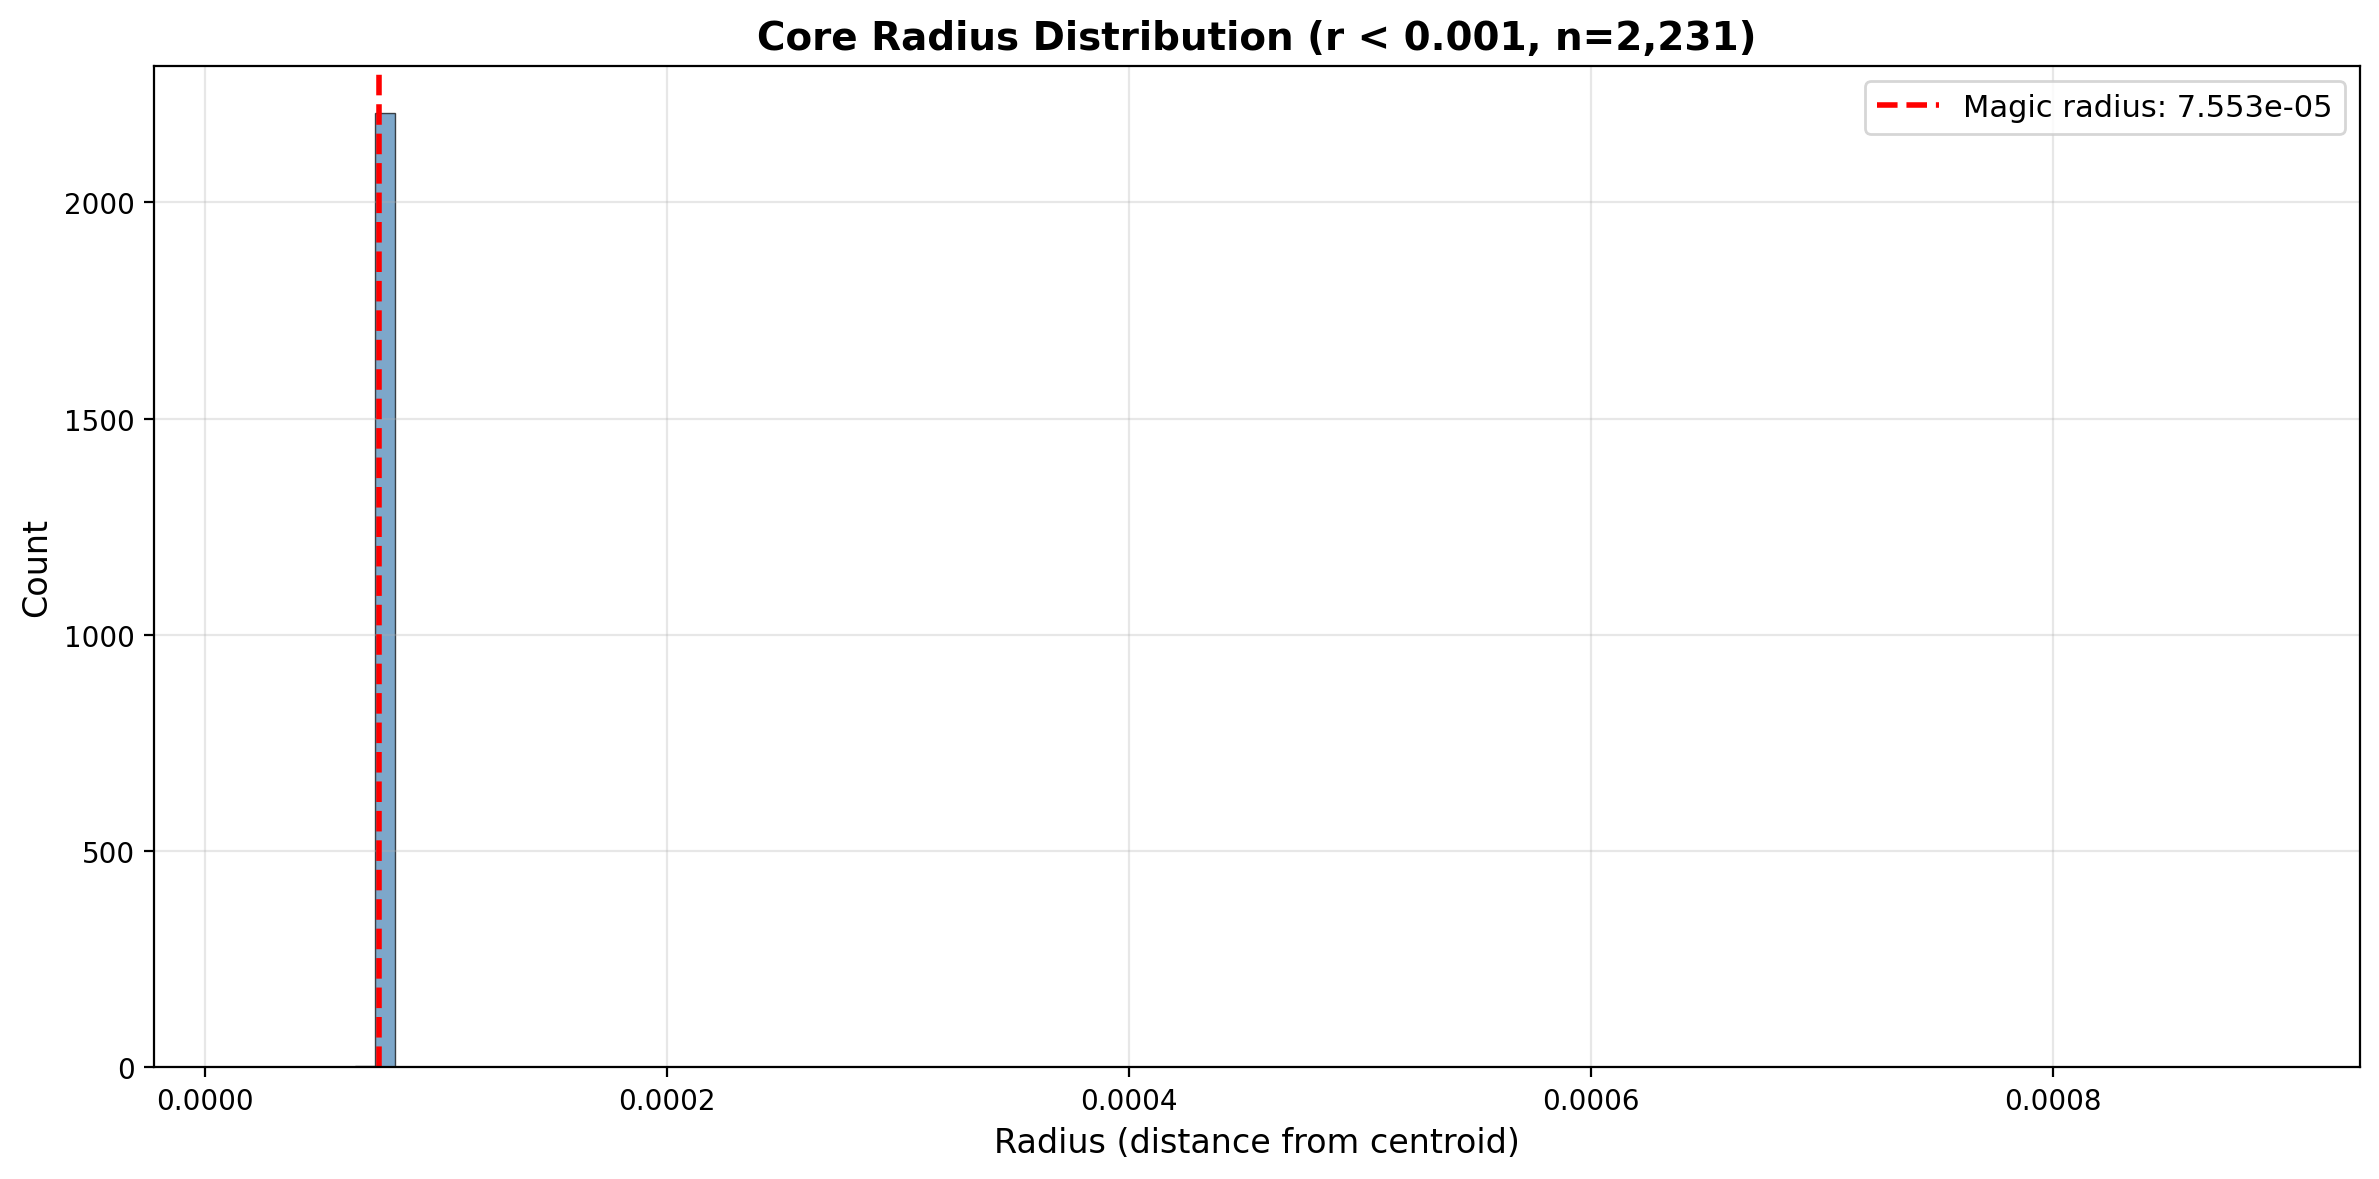

✓ Plotted core radius distribution


In [6]:
print("\nPlotting radius distribution (zoomed to core)...\n")

# Filter to just the core (r < 0.001)
core_mask = r < 0.001
r_core = r[core_mask]

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# Histogram with many bins to see structure
n, bins, patches = ax.hist(r_core.numpy(), bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)

# Mark the magic radius
ax.axvline(MAGIC_RADIUS, color='red', linestyle='--', linewidth=2, label=f'Magic radius: {MAGIC_RADIUS}')

ax.set_xlabel('Radius (distance from centroid)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Core Radius Distribution (r < 0.001, n={core_mask.sum():,})', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Plotted core radius distribution")

## Load Tokenizer and Classify Magic Radius Tokens

In [7]:
print("\nLoading tokenizer...\n")

tokenizer = AutoTokenizer.from_pretrained(f"Qwen/{MODEL_NAME}")

print(f"✓ Loaded tokenizer")


Loading tokenizer...

✓ Loaded tokenizer


## Decode and Classify Magic Radius Tokens

In [8]:
print("\nDecoding tokens at magic radius...\n")

# Get token IDs at magic radius
magic_token_ids = cluster_token_ids[at_magic_radius]

# Decode
decoded = [tokenizer.decode([tid.item()]) for tid in magic_token_ids]

# Classify by script
ad = AlphabetDetector()
scripts = []

for text in decoded:
    text_stripped = text.strip()
    if not text_stripped:
        scripts.append('EMPTY')
    elif ad.is_thai(text_stripped):
        scripts.append('THAI')
    elif ad.is_cjk(text_stripped):
        scripts.append('CJK')
    elif ad.is_latin(text_stripped):
        scripts.append('LATIN')
    elif ad.is_arabic(text_stripped):
        scripts.append('ARABIC')
    elif ad.is_hebrew(text_stripped):
        scripts.append('HEBREW')
    elif ad.is_greek(text_stripped):
        scripts.append('GREEK')
    elif ad.is_cyrillic(text_stripped):
        scripts.append('CYRILLIC')
    else:
        scripts.append('OTHER')

script_counts = Counter(scripts)

print(f"Script distribution at magic radius:")
print(f"{'Script':<12} {'Count':<10} {'Percentage'}")
print("-" * 40)

for script, count in script_counts.most_common():
    pct = count / len(scripts) * 100
    print(f"{script:<12} {count:<10,} {pct:>6.1f}%")


Decoding tokens at magic radius...

Script distribution at magic radius:
Script       Count      Percentage
----------------------------------------


## Token ID Range at Magic Radius

In [9]:
print("\nToken ID statistics at magic radius...\n")

magic_ids_np = magic_token_ids.numpy()

print(f"Token ID range:")
print(f"  Min: {magic_ids_np.min():,}")
print(f"  Max: {magic_ids_np.max():,}")
print(f"  Median: {np.median(magic_ids_np):.0f}")
print(f"  Mean: {magic_ids_np.mean():.0f}")
print(f"  Span: {magic_ids_np.max() - magic_ids_np.min():,} token IDs")


Token ID statistics at magic radius...

Token ID range:


ValueError: zero-size array to reduction operation minimum which has no identity

## Spherical Distribution at Magic Radius

In [ ]:
print("\nSpherical distribution at magic radius...\n")

# Get lat/lon for magic radius tokens
magic_lat = lat_deg[at_magic_radius]
magic_lon = lon_deg[at_magic_radius]

print(f"Latitude range:")
print(f"  [{magic_lat.min().item():.2f}°, {magic_lat.max().item():.2f}°]")
print(f"  Span: {(magic_lat.max() - magic_lat.min()).item():.2f}°")
print()
print(f"Longitude range:")
print(f"  [{magic_lon.min().item():.2f}°, {magic_lon.max().item():.2f}°]")
print(f"  Span: {(magic_lon.max() - magic_lon.min()).item():.2f}°")
print()
print(f"Interpretation:")
print(f"  These tokens form a shell at constant radius r = {MAGIC_RADIUS}")
print(f"  spanning {(magic_lat.max() - magic_lat.min()).item():.1f}° × {(magic_lon.max() - magic_lon.min()).item():.1f}° on the sphere")

## Sample Tokens at Magic Radius

In [ ]:
print("\nSample tokens at magic radius (first 30):")
print(f"{'Token ID':<10} {'Latitude':<12} {'Longitude':<12} {'Script':<10} {'Decoded'}")
print("-" * 80)

for i in range(min(30, len(magic_token_ids))):
    tid = magic_token_ids[i].item()
    lat = magic_lat[i].item()
    lon = magic_lon[i].item()
    script = scripts[i]
    dec = decoded[i]
    
    # Truncate for display
    dec_display = repr(dec)[:30] + '..' if len(repr(dec)) > 32 else repr(dec)
    
    print(f"{tid:<10} {lat:<12.2f} {lon:<12.2f} {script:<10} {dec_display}")